

#### Developed by:
##### 1. Manoj Saxena - Group facilitator
##### 2.Atul Sharma


In [30]:
## Checking the GPU configuration

!nvidia-smi

Wed Dec 23 10:25:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.30                 Driver Version: 390.30                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |  10960MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

 Set the random seed so that results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed

Using TensorFlow backend.


In [3]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

To read the folder name and training and value data and also set the `batch_size` 

In [4]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_dir='/mnt/disks/user/project/PROJECT/Project_data'

##### Plotting

In [6]:
# Def to plot the training/validation 

def plot(history):
    figer, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Define Generator


In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path for project data 
    def initialize_path(self,project_dir):
        self.train_doc = np.random.permutation(open( project_dir+'/'+'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_dir+'/'+'val.csv').readlines())
        self.train_path =  project_dir+'/'+'train'
        self.val_path =    project_dir+'/'+'val'
       
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size and frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    #  Here is the generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_indx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_indx,augment)
                yield batch_data, batch_labels 

            rem_seq=len(t)%batch_size
        
            if (rem_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_indx,augment,rem_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_indx,augment,rem_seq=0):
    
        seq_len = rem_seq if rem_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_indx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_indx),self.image_height,self.image_width,self.channels))

        
        for container in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[container + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_indx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[container + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[container,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[container,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[container,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[container,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[container,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[container,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[container, int(t[container + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## ModelCreation


## Sample Model

In [8]:
class ModelConvolution3D(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
convolution_3d=ModelConvolution3D()
convolution_3d.initialize_path(project_dir)
convolution_3d.initialize_image_properties(image_height=160,image_width=160)
convolution_3d.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
convolution_3d_model=convolution_3d.define_model()
convolution_3d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

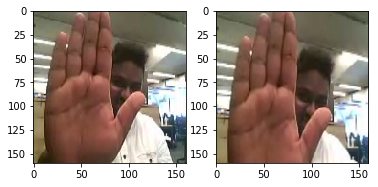

In [10]:
test_generator=ModelConvolution3D()
test_generator.initialize_path(project_dir)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [41]:
convolution_3d.train_model(convolution_3d_model)

Epoch 1/1
67/67 [==============================] - 94s 1s/step - loss: 1.5259 - categorical_accuracy: 0.4442 - val_loss: 1.0530 - val_categorical_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 1.05305, saving model to model_init_2020-12-2310_26_00.571469/model-00001-1.53516-0.44193-1.05305-0.60000.h5


### Below is the error, we had hit the limit on memory resources 

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [42]:
print(" Utilization of memory is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

 Utilization of memory is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [43]:
convo_3d=ModelConvolution3D()
convo_3d.initialize_path(project_dir)
convo_3d.initialize_image_properties(image_height=100,image_width=100)
convo_3d.initialize_hyperparams(frames_to_sample=25,batch_size=30,num_epochs=2)
convo_3d_model=convo_3d.define_model()
print("Total No of Params:", convo_3d_model.count_params())
convo_3d.train_model(convo_3d_model)

Total No of Params: 687813
Epoch 1/2
23/23 [==============================] - 68s 3s/step - loss: 1.6214 - categorical_accuracy: 0.3702 - val_loss: 1.2696 - val_categorical_accuracy: 0.5200

Epoch 00001: val_loss improved from inf to 1.26962, saving model to model_init_2020-12-2310_27_43.359652/model-00001-1.59391-0.38462-1.26962-0.52000.h5
Epoch 2/2
23/23 [==============================] - 55s 2s/step - loss: 1.1947 - categorical_accuracy: 0.5229 - val_loss: 0.9846 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 1.26962 to 0.98465, saving model to model_init_2020-12-2310_27_43.359652/model-00002-1.20077-0.51735-0.98465-0.62000.h5


In [44]:
conv_3d=ModelConvolution3D()
conv_3d.initialize_path(project_dir)
conv_3d.initialize_image_properties(image_height=100,image_width=100)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total No of Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total No of Params: 687813
Epoch 1/2
34/34 [==============================] - 80s 2s/step - loss: 1.6183 - categorical_accuracy: 0.3966 - val_loss: 2.1451 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 2.14508, saving model to model_init_2020-12-2310_29_59.321117/model-00001-1.59897-0.39819-2.14508-0.33000.h5
Epoch 2/2
34/34 [==============================] - 69s 2s/step - loss: 1.3256 - categorical_accuracy: 0.5180 - val_loss: 1.8556 - val_categorical_accuracy: 0.3600

Epoch 00002: val_loss improved from 2.14508 to 1.85556, saving model to model_init_2020-12-2310_29_59.321117/model-00002-1.26157-0.53092-1.85556-0.36000.h5


In [45]:
conv_3d=ModelConvolution3D()
conv_3d.initialize_path(project_dir)
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total no of Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total no of Params: 1736389
Epoch 1/2
45/45 [==============================] - 94s 2s/step - loss: 1.6667 - categorical_accuracy: 0.3971 - val_loss: 0.9839 - val_categorical_accuracy: 0.6100

Epoch 00001: val_loss improved from inf to 0.98391, saving model to model_init_2020-12-2310_32_38.751556/model-00001-1.67462-0.39819-0.98391-0.61000.h5
Epoch 2/2
45/45 [==============================] - 81s 2s/step - loss: 1.0223 - categorical_accuracy: 0.5853 - val_loss: 1.1437 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss did not improve from 0.98391


In [46]:
conv_3d=ModelConvolution3D()
conv_3d.initialize_path(project_dir)
conv_3d.initialize_image_properties(image_height=160,image_width=160)
conv_3d.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d_model=conv_3d.define_model()
print("Total no of Params:", conv_3d_model.count_params())
conv_3d.train_model(conv_3d_model)

Total no of Params: 1736389
Epoch 1/2
23/23 [==============================] - 53s 2s/step - loss: 1.6540 - categorical_accuracy: 0.4088 - val_loss: 1.5611 - val_categorical_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 1.56108, saving model to model_init_2020-12-2310_35_45.063448/model-00001-1.59096-0.41176-1.56108-0.45000.h5
Epoch 2/2
23/23 [==============================] - 39s 2s/step - loss: 1.1187 - categorical_accuracy: 0.5781 - val_loss: 1.1057 - val_categorical_accuracy: 0.5400

Epoch 00002: val_loss improved from 1.56108 to 1.10567, saving model to model_init_2020-12-2310_35_45.063448/model-00002-1.07409-0.57466-1.10567-0.54000.h5


- As we see that **"image resolution"** and **number of frames** have more impact on training time than **batch_size**
- So we can consider the Batch Size appx 15-40
- Now will change the resoulution 160*160, 120*120 according to the model performance


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [47]:
class ConvoModel3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
con_3d1=ConvoModel3D1()
con_3d1.initialize_path(project_dir)
con_3d1.initialize_image_properties(image_height=160,image_width=160)
con_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
con_3d1_model=con_3d1.define_model()
con_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_53 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_54 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 10, 80, 80, 32)    128       
__________

In [49]:
print("Total Params:", con_3d1_model.count_params())
history_model1 = con_3d1.train_model(con_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 68s 4s/step - loss: 1.7167 - categorical_accuracy: 0.3779 - val_loss: 2.6025 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 2.60250, saving model to model_init_2020-12-2310_37_29.376293/model-00001-1.71415-0.37858-2.60250-0.31000.h5
Epoch 2/15
17/17 [==============================] - 51s 3s/step - loss: 1.0971 - categorical_accuracy: 0.5401 - val_loss: 1.1562 - val_categorical_accuracy: 0.5900

Epoch 00002: val_loss improved from 2.60250 to 1.15623, saving model to model_init_2020-12-2310_37_29.376293/model-00002-1.10405-0.53846-1.15623-0.59000.h5
Epoch 3/15
17/17 [==============================] - 58s 3s/step - loss: 0.7930 - categorical_accuracy: 0.6909 - val_loss: 1.1825 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss did not improve from 1.15623
Epoch 4/15
17/17 [==============================] - 58s 3s/step - loss: 0.6537 - categorical_accuracy: 0.7544 - val_loss: 0.

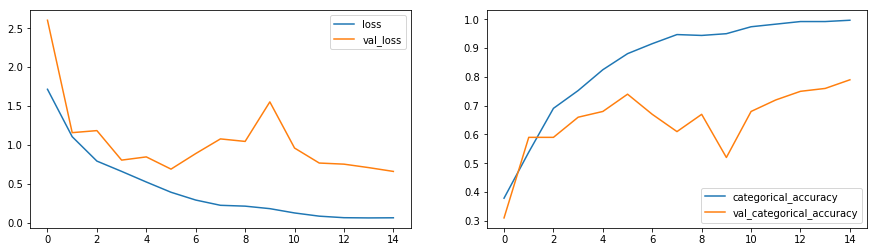

In [50]:
plot(history_model1)

##### Model is clearly overfitting. :(

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [51]:
conv_3d2=ConvoModel3D1()
conv_3d2.initialize_path(project_dir)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_57 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_58 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 10, 80, 80, 32)    128       
__________

In [52]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 140s 4s/step - loss: 1.8918 - categorical_accuracy: 0.3981 - val_loss: 7.7679 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 7.76786, saving model to model_init_2020-12-2310_52_28.204050/model-00001-1.86657-0.39970-7.76786-0.25000.h5
Epoch 2/25
34/34 [==============================] - 123s 4s/step - loss: 1.4076 - categorical_accuracy: 0.5015 - val_loss: 7.9159 - val_categorical_accuracy: 0.2600

Epoch 00002: val_loss did not improve from 7.76786
Epoch 3/25
34/34 [==============================] - 132s 4s/step - loss: 1.1568 - categorical_accuracy: 0.5979 - val_loss: 1.2110 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss improved from 7.76786 to 1.21099, saving model to model_init_2020-12-2310_52_28.204050/model-00003-1.16693-0.59201-1.21099-0.61000.h5
Epoch 4/25
34/34 [==============================] - 133s 4s/step - loss: 1.0861 - categorical_accuracy: 0.6295 - val_loss

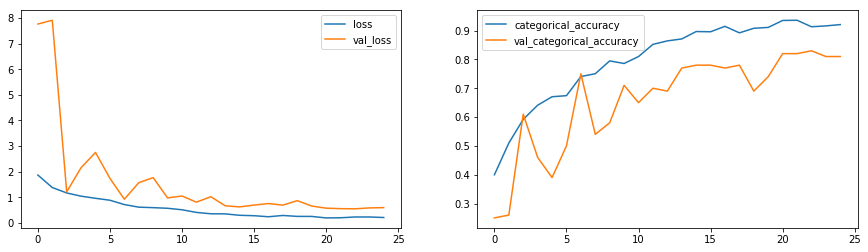

In [53]:
plot(history_model2)

##### We can see  val_loss did not improve from 0.47444 !! 

 Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [54]:
class ModelConvo3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [55]:
conv_3d3=ModelConvo3D3()
conv_3d3.initialize_path(project_dir)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_61 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_61 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_61 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_62 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 8, 60, 60, 32)     128       
__________

In [56]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 95s 4s/step - loss: 2.2244 - categorical_accuracy: 0.3166 - val_loss: 1.2400 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.23999, saving model to model_init_2020-12-2311_48_01.729001/model-00001-2.21083-0.31599-1.23999-0.51000.h5
Epoch 2/25
23/23 [==============================] - 77s 3s/step - loss: 1.6030 - categorical_accuracy: 0.4546 - val_loss: 0.9914 - val_categorical_accuracy: 0.6300

Epoch 00002: val_loss improved from 1.23999 to 0.99144, saving model to model_init_2020-12-2311_48_01.729001/model-00002-1.61533-0.45928-0.99144-0.63000.h5
Epoch 3/25
23/23 [==============================] - 87s 4s/step - loss: 1.3760 - categorical_accuracy: 0.5296 - val_loss: 1.0983 - val_categorical_accuracy: 0.5400

Epoch 00003: val_loss did not improve from 0.99144
Epoch 4/25
23/23 [==============================] - 88s 4s/step - loss: 1.2323 - categorical_accuracy: 0.5581 - val_loss: 0.

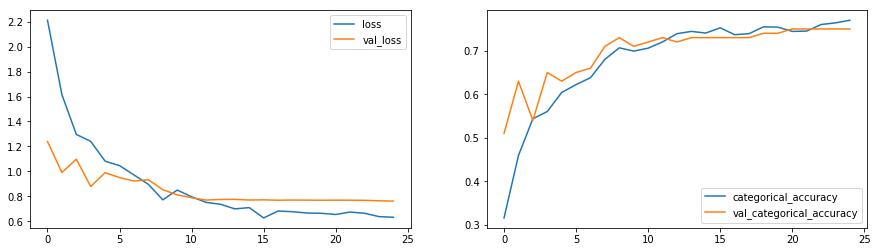

In [57]:
plot(history_model3)

##### Model has a  best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [58]:
class ModelConvo3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [59]:
conv_3d4=ModelConvo3D4()
conv_3d4.initialize_path(project_dir)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_65 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_66 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_65 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [60]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 123s 4s/step - loss: 2.0189 - categorical_accuracy: 0.3385 - val_loss: 8.1785 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss improved from inf to 8.17852, saving model to model_init_2020-12-2312_24_48.925328/model-00001-2.01248-0.34691-8.17852-0.25000.h5
Epoch 2/25
34/34 [==============================] - 96s 3s/step - loss: 1.5341 - categorical_accuracy: 0.4742 - val_loss: 2.6750 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 8.17852 to 2.67497, saving model to model_init_2020-12-2312_24_48.925328/model-00002-1.53686-0.47360-2.67497-0.49000.h5
Epoch 3/25
34/34 [==============================] - 97s 3s/step - loss: 1.1767 - categorical_accuracy: 0.5857 - val_loss: 2.8514 - val_categorical_accuracy: 0.4100

Epoch 00003: val_loss did not improve from 2.67497
Epoch 4/25
34/34 [==============================] - 96s 3s/step - loss: 1.2977 - categorical_accuracy: 0.5574 - val_loss: 1

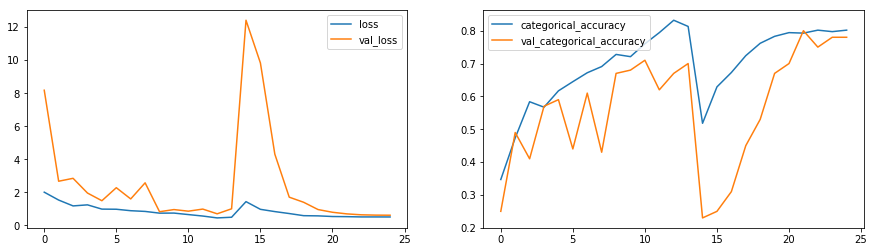

In [61]:
plot(history_model4)

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [62]:
class ModelConvo3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [63]:
conv_3d5=ModelConvo3D5()
conv_3d5.initialize_path(project_dir)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_73 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_73 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_74 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_74 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_106 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_69 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [64]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 111s 3s/step - loss: 1.8917 - categorical_accuracy: 0.3771 - val_loss: 2.0198 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 2.01979, saving model to model_init_2020-12-2313_06_15.583132/model-00001-1.88783-0.37406-2.01979-0.36000.h5
Epoch 2/15
34/34 [==============================] - 97s 3s/step - loss: 1.3711 - categorical_accuracy: 0.4772 - val_loss: 4.2509 - val_categorical_accuracy: 0.3000

Epoch 00002: val_loss did not improve from 2.01979
Epoch 3/15
34/34 [==============================] - 97s 3s/step - loss: 1.1664 - categorical_accuracy: 0.5581 - val_loss: 1.8296 - val_categorical_accuracy: 0.5400

Epoch 00003: val_loss improved from 2.01979 to 1.82960, saving model to model_init_2020-12-2313_06_15.583132/model-00003-1.18008-0.55128-1.82960-0.54000.h5
Epoch 4/15
34/34 [==============================] - 97s 3s/step - loss: 0.9736 - categorical_accuracy: 0.6174 - val_loss: 0

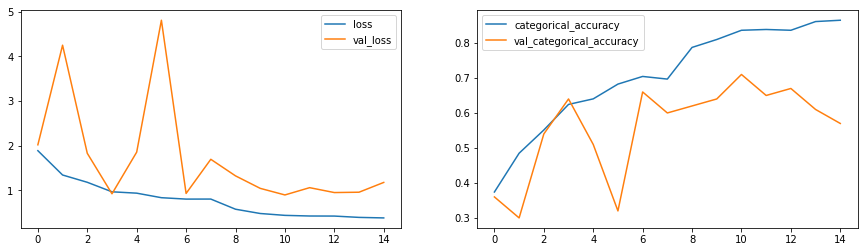

In [65]:
plot(history_model5)

 __Ohh! Here is the Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [66]:
class ModelConvo3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [67]:
conv_3d6=ModelConvo3D6()
conv_3d6.initialize_path(project_dir)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_81 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_81 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_115 (Bat (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_73 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_82 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_116 (Bat (None, 8, 50, 50, 32)     128       
__________

In [68]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - 89s 3s/step - loss: 1.8511 - categorical_accuracy: 0.3514 - val_loss: 1.6216 - val_categorical_accuracy: 0.4700

Epoch 00001: val_loss improved from inf to 1.62161, saving model to model_init_2020-12-2313_31_10.367094/model-00001-1.87522-0.34766-1.62161-0.47000.h5
Epoch 2/20
34/34 [==============================] - 71s 2s/step - loss: 1.1882 - categorical_accuracy: 0.5291 - val_loss: 1.0620 - val_categorical_accuracy: 0.6100

Epoch 00002: val_loss improved from 1.62161 to 1.06195, saving model to model_init_2020-12-2313_31_10.367094/model-00002-1.18393-0.53394-1.06195-0.61000.h5
Epoch 3/20
34/34 [==============================] - 82s 2s/step - loss: 1.0619 - categorical_accuracy: 0.5975 - val_loss: 1.1128 - val_categorical_accuracy: 0.6100

Epoch 00003: val_loss did not improve from 1.06195
Epoch 4/20
34/34 [==============================] - 82s 2s/step - loss: 0.9045 - categorical_accuracy: 0.6431 - val_loss: 0.7

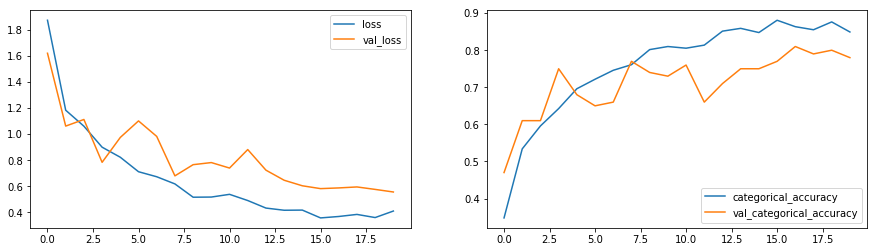

In [69]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 74%

## Model 7 - Reducing the number of parameters again

In [70]:
class ModelConvo3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [71]:
conv_3d7=ModelConvo3D7()
conv_3d7.initialize_path(project_dir)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_85 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_85 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_121 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_77 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_86 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_122 (Bat (None, 8, 60, 60, 32)     128       
__________

In [72]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 96s 3s/step - loss: 1.7796 - categorical_accuracy: 0.3528 - val_loss: 1.3099 - val_categorical_accuracy: 0.5300

Epoch 00001: val_loss improved from inf to 1.30987, saving model to model_init_2020-12-2313_58_57.487277/model-00001-1.78963-0.34917-1.30987-0.53000.h5
Epoch 2/25
34/34 [==============================] - 78s 2s/step - loss: 1.2419 - categorical_accuracy: 0.5180 - val_loss: 1.0383 - val_categorical_accuracy: 0.6400

Epoch 00002: val_loss improved from 1.30987 to 1.03834, saving model to model_init_2020-12-2313_58_57.487277/model-00002-1.22179-0.52262-1.03834-0.64000.h5
Epoch 3/25
34/34 [==============================] - 89s 3s/step - loss: 1.0251 - categorical_accuracy: 0.5857 - val_loss: 0.9711 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 1.03834 to 0.97115, saving model to model_init_2020-12-2313_58_57.487277/model-00003-1.01812-0.59201-0.97115-0.62000.h5
Epoch 4/25
34/34 [==

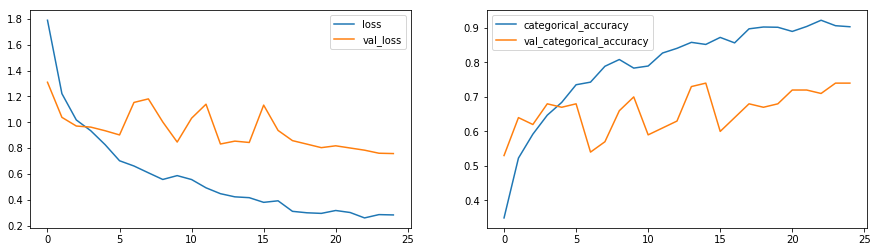

In [73]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 73%

## Model 8 - CNN- LSTM Model

In [26]:
class RNNLSTM1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
rnn_cnn1=RNNLSTM1()
rnn_cnn1.initialize_path(project_dir)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [15]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 193s 6s/step - loss: 1.4535 - categorical_accuracy: 0.3613 - val_loss: 1.2937 - val_categorical_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.29375, saving model to model_init_2020-12-2314_55_56.397258/model-00001-1.44366-0.36199-1.29375-0.50000.h5
Epoch 2/20
34/34 [==============================] - 95s 3s/step - loss: 1.1869 - categorical_accuracy: 0.5052 - val_loss: 1.2788 - val_categorical_accuracy: 0.4800

Epoch 00002: val_loss improved from 1.29375 to 1.27884, saving model to model_init_2020-12-2314_55_56.397258/model-00002-1.20014-0.49698-1.27884-0.48000.h5
Epoch 3/20
34/34 [==============================] - 95s 3s/step - loss: 1.0669 - categorical_accuracy: 0.5780 - val_loss: 1.2232 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss improved from 1.27884 to 1.22325, saving model to model_init_2020-12-2314_55_56.397258/model-00003-1.07038-0.57994-1.22325-0.45000.h5
Epoch 4/20
34/34 [

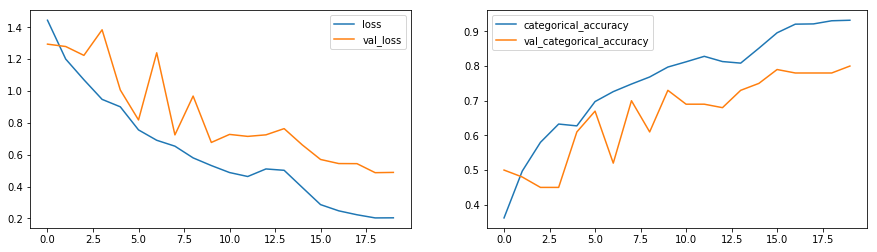

In [16]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 85%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [14]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_dir):
        self.train_doc = np.random.permutation(open(project_dir + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_dir + '/' + 'val.csv').readlines())
        self.train_path = project_dir + '/' + 'train'
        self.val_path =  project_dir + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

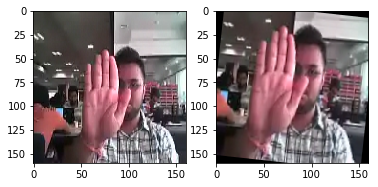

In [15]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_dir)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [19]:
class ModelConvo3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d9=ModelConvo3D9()
conv_3d9.initialize_path(project_dir)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 80, 80, 32)    128       
__________

In [21]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - 174s 5s/step - loss: 2.0352 - categorical_accuracy: 0.3499 - val_loss: 1.4792 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-12-2315_43_20.566819/model-00001-2.00330-0.35445-1.47915-0.51000.h5
Epoch 2/20
34/34 [==============================] - 116s 3s/step - loss: 1.5637 - categorical_accuracy: 0.4982 - val_loss: 0.8913 - val_categorical_accuracy: 0.7000

Epoch 00002: saving model to model_init_2020-12-2315_43_20.566819/model-00002-1.59719-0.48567-0.89132-0.70000.h5
Epoch 3/20
34/34 [==============================] - 119s 3s/step - loss: 1.2573 - categorical_accuracy: 0.5545 - val_loss: 1.0054 - val_categorical_accuracy: 0.6800

Epoch 00003: saving model to model_init_2020-12-2315_43_20.566819/model-00003-1.27851-0.54751-1.00542-0.68000.h5
Epoch 4/20
34/34 [==============================] - 118s 3s/step - loss: 1.1619 - categorical_accuracy: 0.6122 - val_loss: 0.9055 - val_categ

In [ ]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [22]:
class ModelConvo3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d10=ModelConvo3D10()
conv_3d10.initialize_path(project_dir)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 60, 60, 32)     128       
__________

In [24]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 112s 5s/step - loss: 2.1448 - categorical_accuracy: 0.3261 - val_loss: 1.0568 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-12-2316_27_27.695142/model-00001-2.15574-0.32579-1.05683-0.58000.h5
Epoch 2/25
23/23 [==============================] - 78s 3s/step - loss: 1.6253 - categorical_accuracy: 0.4821 - val_loss: 1.1341 - val_categorical_accuracy: 0.5300

Epoch 00002: saving model to model_init_2020-12-2316_27_27.695142/model-00002-1.51462-0.48793-1.13411-0.53000.h5
Epoch 3/25
23/23 [==============================] - 80s 3s/step - loss: 1.2866 - categorical_accuracy: 0.5498 - val_loss: 1.0236 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-12-2316_27_27.695142/model-00003-1.29748-0.54525-1.02361-0.55000.h5
Epoch 4/25
23/23 [==============================] - 80s 3s/step - loss: 1.2285 - categorical_accuracy: 0.6057 - val_loss: 0.8242 - val_categori

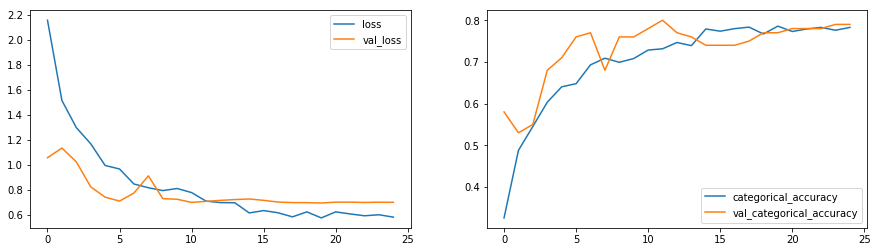

In [25]:
plot(history_model10)

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [16]:
class ModelConvo3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d11=ModelConvo3D11()
conv_3d11.initialize_path(project_dir)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [18]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 189s 6s/step - loss: 2.3689 - categorical_accuracy: 0.2910 - val_loss: 2.1298 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2020-12-2404_19_30.680507/model-00001-2.34933-0.29412-2.12985-0.33000.h5
Epoch 2/25
34/34 [==============================] - 96s 3s/step - loss: 1.7344 - categorical_accuracy: 0.4352 - val_loss: 1.9366 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-12-2404_19_30.680507/model-00002-1.74071-0.43363-1.93664-0.50000.h5
Epoch 3/25
34/34 [==============================] - 96s 3s/step - loss: 1.4652 - categorical_accuracy: 0.4963 - val_loss: 1.0284 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-12-2404_19_30.680507/model-00003-1.46398-0.49623-1.02841-0.64000.h5
Epoch 4/25
34/34 [==============================] - 96s 3s/step - loss: 1.3321 - categorical_accuracy: 0.5526 - val_loss: 1.1946 - val_categori

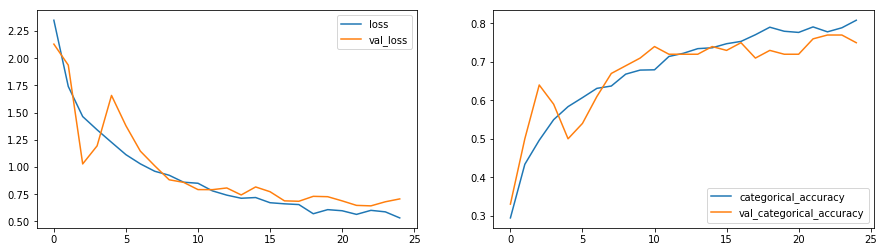

In [19]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [20]:
class ModelConvo3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d12=ModelConvo3D12()
conv_3d12.initialize_path(project_dir)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_14 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 60, 60, 16)     0         
__________

In [22]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 106s 3s/step - loss: 1.9998 - categorical_accuracy: 0.3142 - val_loss: 3.5115 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2020-12-2405_04_38.813662/model-00001-2.00575-0.31373-3.51148-0.20000.h5
Epoch 2/25
34/34 [==============================] - 97s 3s/step - loss: 1.6440 - categorical_accuracy: 0.4202 - val_loss: 2.7197 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2020-12-2405_04_38.813662/model-00002-1.62932-0.42232-2.71967-0.29000.h5
Epoch 3/25
34/34 [==============================] - 96s 3s/step - loss: 1.4345 - categorical_accuracy: 0.4845 - val_loss: 2.8299 - val_categorical_accuracy: 0.2700

Epoch 00003: saving model to model_init_2020-12-2405_04_38.813662/model-00003-1.44402-0.48416-2.82990-0.27000.h5
Epoch 4/25
34/34 [==============================] - 97s 3s/step - loss: 1.3433 - categorical_accuracy: 0.5199 - val_loss: 3.7121 - val_categori

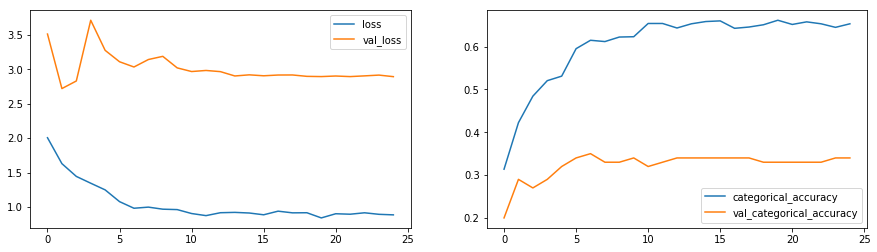

In [23]:
plot(history_model12)

## After doing all the experiments with many models, we finalized Model 8 - CNN+LSTM, which performed well.
__Reason:__

__- (Training Accuracy : 92%, Validation Accuracy : 80%)__

__- Number of Parameters(1,657,445) these are less according to other models performance__

__- Learning rate gradually decreasing after 16 Epoch__


__The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing

In [24]:
import time
from keras.models import load_model
model = load_model('model_init_2020-12-2314_55_56.397258/model-00019-0.20355-0.93062-0.48739-0.78000.h5')

In [27]:
test_generator=RNNLSTM1()
test_generator.initialize_path(project_dir)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [28]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [29]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 4 1 1 1 1 3 0 2 1 3 0 2 4 3 3 1 2 0 4]
